In [20]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import os
import gc
from model_ensemble_toolbox import stacking

In [21]:
print("--- Loading Data ---")

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
datasert_df = pd.read_csv('personality_dataset.csv')#已经用mean填充了数值,mode填充了分类型数据

print("--- Engineering 'match_p' feature using merge ---")

merge_cols = [
    'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
    'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
    'Post_frequency'
]

# 2. 准备 datasert_df_prep，解决冲突
#    - 按 merge_cols 分组
#    - 对每个组的 'Personality' 列计算众数
#    - .mode()[0] 确保即使众数有多个（平局），也只取第一个，从而保证结果的唯一性
datasert_df_prep = datasert_df.groupby(merge_cols).agg(
    match_p=('Personality', lambda x: x.mode()[0])
).reset_index()

# datasert_df_prep 现在对于每一组 merge_cols 都只有一行，且 match_p 列是计算出的众数
# 例如：
# Time_spent_Alone | ... | match_p
# -----------------|-----|----------
# 1.0              | ... | Introvert
# 2.0              | ... | Extrovert

# 3. 执行左连接 (Left Merge)
#    你的原始合并代码现在可以安全地使用了
train_df = train_df.merge(datasert_df_prep, how='left', on=merge_cols)
test_df = test_df.merge(datasert_df_prep, how='left', on=merge_cols)

# 检查结果
print("使用众数处理后 train_df 的信息：")
train_df.info()
print("\n查看新列的前几行：")
print(train_df[['id'] + merge_cols + ['match_p']].head())

--- Loading Data ---
--- Engineering 'match_p' feature using merge ---
使用众数处理后 train_df 的信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
 9   match_p                    121 non-null    object 
dtypes: float64(5), int64(1), object(4)
memory usage: 1.4+ MB

查看新列的前几行：
   id  Time_spent_Alone Stage_fear  Social_event_atte

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
 9   match_p                    121 non-null    object 
dtypes: float64(5), int64(1), object(4)
memory usage: 1.4+ MB


In [23]:
print("--- Performing Imputation and Initial Feature Prep ---")
train_id = train_df['id']; test_id = test_df['id']
y_train_series = train_df['Personality']
all_data = pd.concat([train_df.drop(['id', 'Personality'], axis=1), test_df.drop('id', axis=1)], ignore_index=True)

--- Performing Imputation and Initial Feature Prep ---


In [24]:
def fill_missing_by_quantile_group(df, group_source_col, target_col):
    """
    按分位数分组，使用组内中位数填充目标列的缺失值。

    该函数实现了一种智能的缺失值填充方法。它首先根据 `group_source_col` 列的
    数值分布(分位数),将数据分成四组(0-25%, 25-50%, 50-75%, 75-100%).然后，
    计算每个组内 `target_col` 列的中位数。最后，使用各行对应分组的中位数来填充
    `target_col` 中的缺失值(NaN)。

    这种方法比使用全局中位数填充更精细，特别适用于源列和目标列之间存在相关性的场景
    （例如，使用年龄分组来填充收入的缺失值）。

    参数:
        df (pd.DataFrame): 待处理的Pandas DataFrame。
        group_source_col (str): 用于分箱和分组的源列名。此列应该是数值类型，以便计算分位数。
        target_col (str): 包含缺失值(NaN)并需要被填充的目标列名。

    返回值:
        pd.DataFrame: 填充了缺失值后的DataFrame。
    """
        
    temp_bin_col = f'{group_source_col}_bin'
    df[temp_bin_col] = pd.qcut(df[group_source_col], 
                        q=[0, 0.25, 0.5, 0.75, 1.0], 
                        labels=[1,2,3,4], 
                        duplicates='drop')
    df[target_col] = df[target_col].fillna(df.groupby(temp_bin_col)[target_col].transform('median'))
    df.drop(columns=[temp_bin_col], inplace=True)
    return df

In [25]:
#认为Social_event_attendance和Time_spend_Alone有关，用前者分箱为后者取中位数缺失值
#认为Going_outside和Time_spend_Alone有关，用前者分箱为后者取中位数填充缺失值
#再用全部的中位数fillna还没有被补全的Time_spend_alone
all_data = fill_missing_by_quantile_group(all_data, 'Social_event_attendance', 'Time_spent_Alone')
all_data = fill_missing_by_quantile_group(all_data, 'Going_outside', 'Time_spent_Alone')
all_data['Time_spent_Alone'].fillna(all_data['Time_spent_Alone'].median(), inplace=True)

all_data = fill_missing_by_quantile_group(all_data, 'Going_outside', 'Social_event_attendance')
all_data = fill_missing_by_quantile_group(all_data, 'Friends_circle_size', 'Social_event_attendance')
all_data['Social_event_attendance'].fillna(all_data['Social_event_attendance'].median(), inplace=True)

all_data = fill_missing_by_quantile_group(all_data, 'Social_event_attendance', 'Going_outside')
all_data['Going_outside'].fillna(all_data['Going_outside'].median(), inplace=True)

all_data = fill_missing_by_quantile_group(all_data, 'Post_frequency', 'Friends_circle_size')
all_data = fill_missing_by_quantile_group(all_data, 'Going_outside', 'Friends_circle_size')
all_data['Friends_circle_size'].fillna(all_data['Friends_circle_size'].median(), inplace=True)

all_data = fill_missing_by_quantile_group(all_data, 'Friends_circle_size', 'Post_frequency')
all_data['Post_frequency'].fillna(all_data['Post_frequency'].median(), inplace=True)

In [26]:
numerical_features = all_data.select_dtypes(include=np.number).columns.tolist()

In [27]:
print("--- Creating Final Advanced Features ---")
all_data['social_mean'] = all_data[numerical_features].mean(axis=1)
all_data['social_std'] = all_data[numerical_features].std(axis=1)
all_data['social_sum'] = all_data[numerical_features].sum(axis=1)

--- Creating Final Advanced Features ---


In [28]:
# kmeans方法获得聚类特征
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
all_data['cluster'] = kmeans.fit_predict(all_data[numerical_features])

In [29]:
# 获得多项式特征
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False) # interaction_only=False gives x*y AND x^2
# 同时生成多项式特征（如 a^2, b^2）和交互特征（如 a*b）；True只生成交互特征
poly_features = poly.fit_transform(all_data[numerical_features])
poly_df = pd.DataFrame(poly_features, 
                        columns=poly.get_feature_names_out(numerical_features))
poly_df.drop(columns=numerical_features, inplace=True)
all_data = pd.concat([all_data.reset_index(drop=True), poly_df], axis=1)

In [30]:
# 填充分类型缺失值，用Unknown填充
all_data.fillna({'Stage_fear': 'Unknown', 'Drained_after_socializing': 'Unknown', 'match_p': 'Unknown'}, inplace=True)
all_data = pd.get_dummies(all_data, 
                            columns=['Stage_fear', 'Drained_after_socializing', 'match_p', 'cluster'], 
                            prefix=['Stage', 'Drained', 'match', 'cluster'])


X = all_data[:len(train_df)]
X_test = all_data[len(train_df):]

y_encoded = LabelEncoder().fit_transform(y_train_series)

[I 2025-07-19 18:13:58,355] A new study created in memory with name: no-name-abb3ee22-b57a-4155-b3dc-fab41ff2b29a
[I 2025-07-19 18:16:17,631] Trial 0 finished with value: 0.9643024794531065 and parameters: {'iterations': 1843, 'learning_rate': 0.0394364478286337, 'depth': 11, 'subsample': 0.9751927798120863, 'l2_leaf_reg': 4.027346637618804}. Best is trial 0 with value: 0.9643024794531065.
[I 2025-07-19 18:17:08,660] Trial 1 finished with value: 0.966799242253468 and parameters: {'iterations': 1157, 'learning_rate': 0.02271808698193913, 'depth': 10, 'subsample': 0.9820567374856534, 'l2_leaf_reg': 1.386335653172996}. Best is trial 1 with value: 0.966799242253468.
[I 2025-07-19 18:18:49,597] Trial 2 finished with value: 0.9684187710855158 and parameters: {'iterations': 1286, 'learning_rate': 0.015820570374161434, 'depth': 11, 'subsample': 0.6636995451187776, 'l2_leaf_reg': 2.627924037719889}. Best is trial 2 with value: 0.9684187710855158.
[I 2025-07-19 18:20:30,018] Trial 3 finished wit


Best Optuna Parameters in CatBoost: {'iterations': 1381, 'learning_rate': 0.012386458064498444, 'depth': 6, 'subsample': 0.9121715845821318, 'l2_leaf_reg': 9.530531760981827}
0:	learn: 0.6730179	total: 6.66ms	remaining: 9.19s
1:	learn: 0.6535320	total: 14ms	remaining: 9.64s
2:	learn: 0.6345648	total: 21.2ms	remaining: 9.74s
3:	learn: 0.6166507	total: 28.1ms	remaining: 9.68s
4:	learn: 0.5987435	total: 36ms	remaining: 9.9s
5:	learn: 0.5818903	total: 43.7ms	remaining: 10s
6:	learn: 0.5658935	total: 52.1ms	remaining: 10.2s
7:	learn: 0.5501115	total: 59.8ms	remaining: 10.3s
8:	learn: 0.5350218	total: 66.9ms	remaining: 10.2s
9:	learn: 0.5204666	total: 73.1ms	remaining: 10s
10:	learn: 0.5065632	total: 77.8ms	remaining: 9.7s
11:	learn: 0.4929316	total: 82ms	remaining: 9.35s
12:	learn: 0.4798887	total: 85.6ms	remaining: 9.01s
13:	learn: 0.4674681	total: 88.6ms	remaining: 8.65s
14:	learn: 0.4553440	total: 91.4ms	remaining: 8.32s
15:	learn: 0.4437664	total: 93.8ms	remaining: 8s
16:	learn: 0.4325

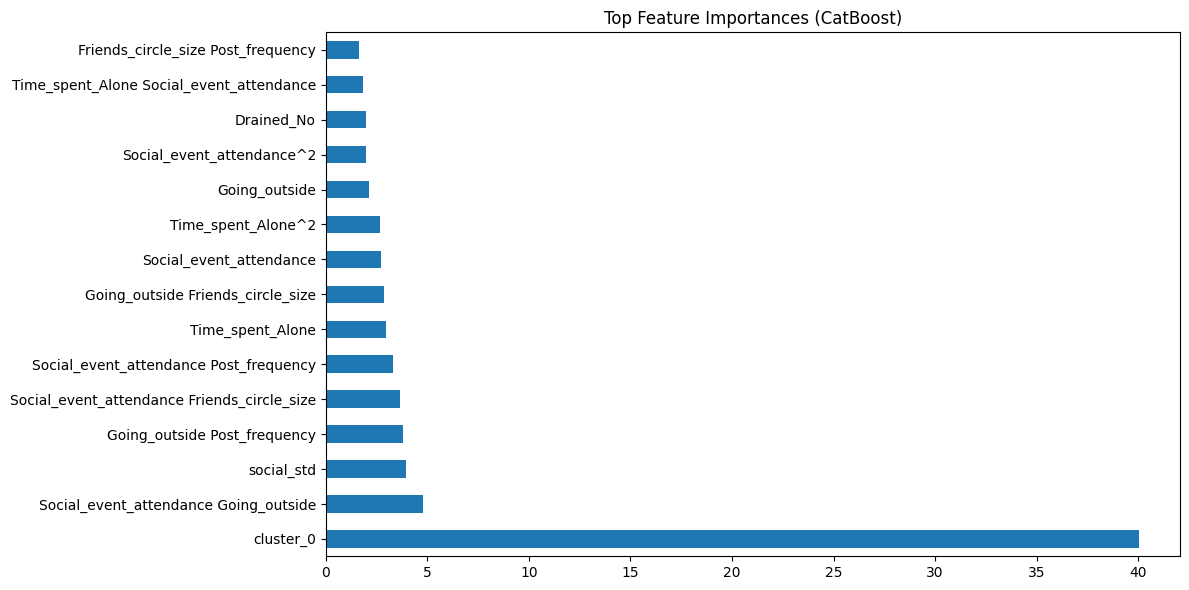

[I 2025-07-19 18:25:53,463] A new study created in memory with name: no-name-6a73dd4c-9940-45e0-b423-68262617417c
[I 2025-07-19 18:25:57,158] Trial 0 finished with value: 0.9637624949728615 and parameters: {'n_estimators': 260, 'max_depth': 10, 'learning_rate': 0.07488339778583392, 'subsample': 0.6983131136288978, 'colsample_bytree': 0.5478444506198232}. Best is trial 0 with value: 0.9637624949728615.
[I 2025-07-19 18:26:01,630] Trial 1 finished with value: 0.9620754259802522 and parameters: {'n_estimators': 315, 'max_depth': 6, 'learning_rate': 0.179693830325476, 'subsample': 0.8666224054668801, 'colsample_bytree': 0.7707942774259858}. Best is trial 0 with value: 0.9637624949728615.
[I 2025-07-19 18:26:11,977] Trial 2 finished with value: 0.9694984657833476 and parameters: {'n_estimators': 168, 'max_depth': 5, 'learning_rate': 0.04832882461139469, 'subsample': 0.660040462006327, 'colsample_bytree': 0.7204010337371611}. Best is trial 2 with value: 0.9694984657833476.
[I 2025-07-19 18:2


Best Optuna Parameters in xgboost: {'n_estimators': 118, 'max_depth': 3, 'learning_rate': 0.10305066219444205, 'subsample': 0.8254739470830968, 'colsample_bytree': 0.959447125752827}

Tuned XGBoost Validation Accuracy: 0.9741
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2740
           1       0.95      0.95      0.95       965

    accuracy                           0.97      3705
   macro avg       0.97      0.97      0.97      3705
weighted avg       0.97      0.97      0.97      3705



<Figure size 1200x600 with 0 Axes>

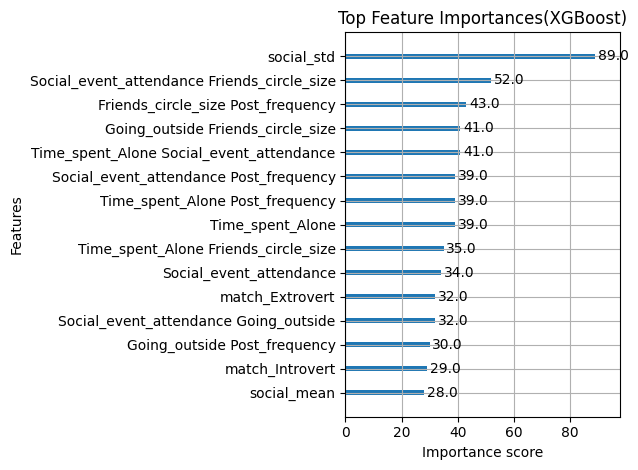

[I 2025-07-19 18:28:17,897] A new study created in memory with name: no-name-e2e28cc8-2a24-4155-927c-585ed816231e
[I 2025-07-19 18:29:30,972] Trial 0 finished with value: 0.9622779147160814 and parameters: {'n_estimators': 1593, 'learning_rate': 0.021481602779452096, 'num_leaves': 185, 'subsample': 0.7037520392760445, 'colsample_bytree': 0.7507374464547029}. Best is trial 0 with value: 0.9622779147160814.
[I 2025-07-19 18:30:02,745] Trial 1 finished with value: 0.9619405191377997 and parameters: {'n_estimators': 1123, 'learning_rate': 0.08916046757118166, 'num_leaves': 215, 'subsample': 0.7974303160732967, 'colsample_bytree': 0.9249016974934481}. Best is trial 0 with value: 0.9622779147160814.
[I 2025-07-19 18:31:39,018] Trial 2 finished with value: 0.9627503040467523 and parameters: {'n_estimators': 1892, 'learning_rate': 0.012986399474632261, 'num_leaves': 177, 'subsample': 0.9251945879031442, 'colsample_bytree': 0.7746491226301546}. Best is trial 2 with value: 0.9627503040467523.
[I


Best Optuna Parameters in LightGBM: {'n_estimators': 751, 'learning_rate': 0.010008926737066937, 'num_leaves': 51, 'subsample': 0.8702871361529005, 'colsample_bytree': 0.6736100369524085}

Tuned LightGBM Validation Accuracy: 0.9738
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2740
           1       0.95      0.95      0.95       965

    accuracy                           0.97      3705
   macro avg       0.97      0.97      0.97      3705
weighted avg       0.97      0.97      0.97      3705



<Figure size 1200x600 with 0 Axes>

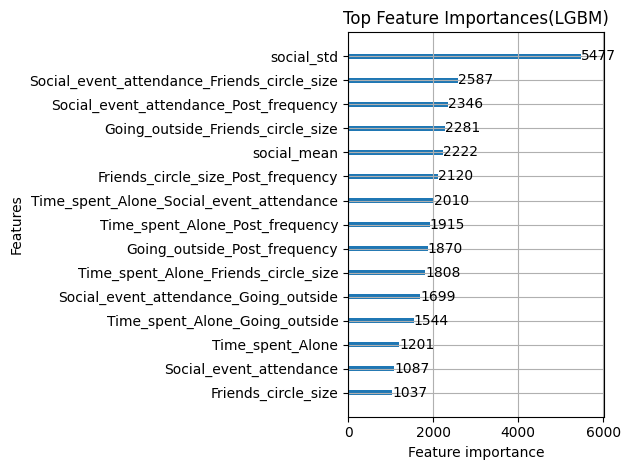

--- FOLD 1/10 ---
  Training cat...
  Training xgb...
  Training lgb...
--- FOLD 2/10 ---
  Training cat...
  Training xgb...
  Training lgb...
--- FOLD 3/10 ---
  Training cat...
  Training xgb...
  Training lgb...
--- FOLD 4/10 ---
  Training cat...
  Training xgb...
  Training lgb...
--- FOLD 5/10 ---
  Training cat...
  Training xgb...
  Training lgb...
--- FOLD 6/10 ---
  Training cat...
  Training xgb...
  Training lgb...
--- FOLD 7/10 ---
  Training cat...
  Training xgb...
  Training lgb...
--- FOLD 8/10 ---
  Training cat...
  Training xgb...
  Training lgb...
--- FOLD 9/10 ---
  Training cat...
  Training xgb...
  Training lgb...
--- FOLD 10/10 ---
  Training cat...
  Training xgb...
  Training lgb...


In [31]:
final_predictions = stacking(X, y_encoded, X_test, n_splits=10)

In [32]:

le_final = LabelEncoder().fit(['Extrovert', 'Introvert']); final_labels = le_final.inverse_transform(final_predictions)
submission_df = pd.DataFrame({'id': test_id, 'Personality': final_labels})
submission_df.to_csv('submission_final_advanced_feats_v2.csv', index=False)
print("\n✅ Final submission file 'submission_final_advanced_feats_v2.csv' created!")


✅ Final submission file 'submission_final_advanced_feats_v2.csv' created!
